In [18]:
import networkx as nx
import osmnx as ox
%matplotlib inline
import pandas as pd
import numpy as np
import os

In [2]:
data = pd.read_csv("../Data/data_cleaned.csv")
data = data[["start station id", "start station latitude", "start station longitude", "end station id", "end station latitude", "end station longitude"]]

In [3]:
stations1 = data.groupby("start station id").first()
stations2 = data.groupby("end station id").first()

In [4]:
stations1.drop(["end station id", "end station latitude", "end station longitude"], inplace =True, axis=1)
stations2.drop(["start station id", "start station latitude", "start station longitude"],axis=1,inplace=True)

stations1.index.name="id"
stations2.index.name="id"
stations1=stations1.set_axis(["latitude","longitude"],axis=1)
stations2=stations2.set_axis(["latitude","longitude"],axis=1)

stations = pd.concat([stations1,stations2])
stations = stations[~stations.index.duplicated(keep="first")]
stations

,latitude,longitude
id,,
72.0,40.767272,-73.993929
79.0,40.719116,-74.006667
82.0,40.711174,-74.000165
83.0,40.683826,-73.976323
119.0,40.696089,-73.978034
...,...,...
3481.0,40.716490,-74.041050
3638.0,40.724294,-74.035483
3639.0,40.719252,-74.034234


In [5]:
del data
del stations1
del stations2

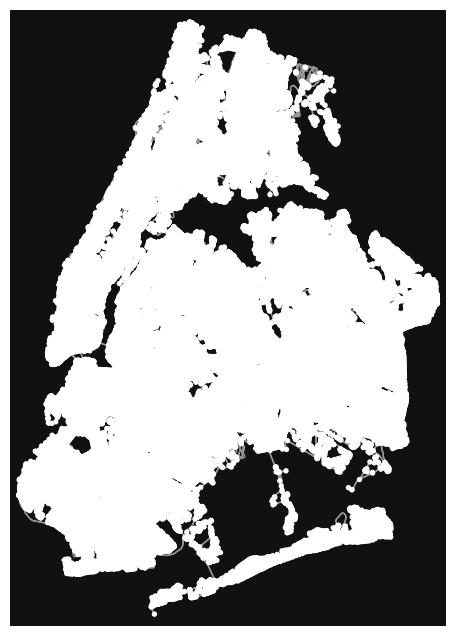

In [19]:
G = ox.graph_from_place("New York, New York, USA", network_type="bike")
G=ox.utils_graph.get_largest_component(G,strongly=True) #Otherwise routing can fail
fig, ax = ox.plot_graph(G)

In [20]:
station_to_node = {}
station_to_dist = {}
failed_nodes = 0
n = 0
for i,station in stations.iterrows():
    if n % 10 == 0:
        print(n)
    if not station.name in station_to_node:
        node,dist = ox.distance.nearest_nodes(G, Y=station["latitude"], X=station["longitude"],return_dist=True)
        station_to_node[station.name] = node
        station_to_dist[station.name] = dist
        if dist > 100:
            failed_nodes += 1 
    n+=1
print(failed_nodes)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
33


In [21]:
nx.shortest_path_length(G,station_to_node[72.0],station_to_node[79.0],weight="length")
#google maps claims about 6.5 km

6100.81

In [22]:
data_chunks = pd.read_csv("../Data/data_cleaned.csv",chunksize=1e6)

In [26]:
#This likely takes hours
output_path="../Data/data_cleaned_processed.csv"
distances = {}
n = 0
for chunk in data_chunks:
    chunk["distance"] = np.nan
    for i,trip in chunk.iterrows():
        route = frozenset([trip["start station id"],trip["end station id"]])
        if not route in distances:
            node1 = station_to_node[trip["start station id"]]
            node2 = station_to_node[trip["end station id"]]
            distances[route] = nx.shortest_path_length(G,node1,node2,weight="length")
        chunk.at[i,"distance"]=distances[route]
        n+=1
        if n % 1e3 == 0:
            print(n)
    chunk.to_csv(output_path, mode='a', header=not os.path.exists(output_path))


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000


KeyboardInterrupt: 